# Dropout as a Bayesian Approximation: Complete Reproduction

This notebook reproduces all experiments from Gal & Ghahramani (2016) *“Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning”*.

In [3]:
# !pip install -q torch torchvision scikit-learn openml tqdm matplotlib seaborn
import math, random, pathlib, urllib.request, gzip, io, warnings, itertools
from types import SimpleNamespace
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F, torch.utils.data as tud
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0);  np.random.seed(0);  random.seed(0)
if torch.cuda.is_available(): torch.cuda.manual_seed(0)
print("🌟  running on", DEVICE)


🌟  running on cuda


In [4]:
# ------------------------------------------------------------------
#  Boston Housing loader  (no external dependencies beyond pandas/numpy)
# ------------------------------------------------------------------
import urllib.request, io, pathlib, numpy as np, pandas as pd
from types import SimpleNamespace

class BostonDataset(SimpleNamespace):
    """Replica of sklearn.datasets.load_boston() output.

    Parameters
    ----------
    local_path : str or Path, optional
        If given, read the raw StatLib file from disk instead of downloading.
    as_frame : bool, default False
        If True, return pandas DataFrame/Series instead of numpy arrays.
    """

    url = "https://lib.stat.cmu.edu/datasets/boston"
    _cols = [
        "CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX",
        "PTRATIO","B","LSTAT","MEDV"
    ]

    @classmethod
    def load(cls, local_path=None, as_frame=False):
        text = (
            pathlib.Path(local_path).read_text()
            if local_path is not None
            else urllib.request.urlopen(cls.url).read().decode()
        )

        lines  = [ln.strip() for ln in text.splitlines()]
        start  = next(i for i,ln in enumerate(lines) if ln and ln[0].isdigit())
        lines  = lines[start:]

        # Each house occupies TWO lines in the raw file
        rows = []
        for i in range(0, len(lines), 2):
            part1 = np.fromstring(lines[i]  , sep=" ")
            part2 = np.fromstring(lines[i+1], sep=" ")
            rows.append(np.hstack((part1, part2)))

        data = np.vstack(rows)                        # 506 × 14
        df   = pd.DataFrame(data, columns=cls._cols)

        if as_frame:
            X, y = df.iloc[:,:-1], df["MEDV"]
        else:
            X, y = df.iloc[:,:-1].values, df["MEDV"].values

        descr = (
            "Boston Housing dataset\n"
            "Harrison & Rubinfeld (1978) — 506 observations, 13 predictors, MEDV target"
        )

        return cls(
            data=X,
            target=y,
            feature_names=cls._cols[:-1],
            frame=df if as_frame else None,
            DESCR=descr,
        )

# Convenience wrapper so old code works:
def load_boston(*, as_frame=False, local_path=None):
    """
    Mimic sklearn.datasets.load_boston().

    Examples
    --------
    >>> boston = load_boston()
    >>> X, y = boston.data, boston.target
    """
    return BostonDataset.load(local_path=local_path, as_frame=as_frame)


def load_power_plant(path="power_plant.csv", *, as_frame=False):
    """
    Loads the Combined Cycle Power Plant dataset from CSV.

    Parameters:
    -----------
    path : str
        Path to the power plant CSV file.
    as_frame : bool
        If True, returns pandas DataFrame; otherwise, NumPy arrays.

    Returns:
    --------
    A SimpleNamespace with:
        .data         -> Features (X)
        .target       -> Target values (y)
        .feature_names-> List of feature column names
        .frame        -> Full DataFrame (if as_frame=True)
        .DESCR        -> Short description
    """
    df = pd.read_csv(path)
    if "PE" not in df.columns:
        raise ValueError("Expected target column 'PE' not found in CSV.")

    X = df.drop(columns="PE")
    y = df["PE"]

    return SimpleNamespace(
        data=X.values if not as_frame else X,
        target=y.values if not as_frame else y,
        feature_names=X.columns.tolist(),
        frame=df if as_frame else None,
        DESCR="UCI Combined Cycle Power Plant dataset (from CSV)"
    )

In [5]:
pp = load_power_plant("power_plant.csv")  # or your custom filename
X, y = pp.data, pp.target
print(X.shape, y.shape)  # Should be (9568, 4)


(9568, 4) (9568,)


In [6]:
# ================================================================
#  UCI REGRESSION – UNIVERSAL LOADER
# ================================================================
from sklearn.datasets import  fetch_openml
from types import SimpleNamespace

# ---- registry ---------------------------------------------------
UCI = {
    "Boston Housing"     : ("Boston",                   44959 , None, 13),
    "Concrete"           : ("concrete_compressive_strength",44959,None,  9),
    "Energy"             : ("EnergyEfficiency",        43338 ,    "Y1",  8),   # heating load
    "Kin8nm"             : ("kin8nm",              44980 ,        None,  8),
    "Naval"              : ("NavalPropulsion",     44969 ,        None, 16),   # GT compressor decay
    "Power Plant"        : ("power-plant-output-436",  44959 ,    None,  4),
    "Protein"            : ("ProteinStructure",     42903 ,       "RMSD",  9),
    "Wine Quality Red"   : ("wine_quality",       40691 ,       None,11),
    "Yacht"              : ("yacht-hydrodynamics",   42370 ,      None,  6),
    "Year Prediction MSD": ("YearPredictionMSD",      46672 ,     None,90),
}
def load_uci(name, as_frame=True):
    if name == "Boston Housing":
        return load_boston(as_frame=as_frame)          # custom helper
    elif name == "Power Plant":
        return load_power_plant( as_frame=as_frame)

    name,data_id, tgt, _ = UCI[name]

    ds  = fetch_openml(data_id=data_id, as_frame=True, parser="auto")
    yco = tgt or ds.target.name or ds.target_column
    df  = ds.frame

    y   = df[yco].astype("float32")
    X   = df.drop(columns=[yco]).select_dtypes(include=["number"]).astype("float32")

    return SimpleNamespace(
        data   = X if as_frame else X.values,
        target = y if as_frame else y.values,
        frame  = df if as_frame else None,
        feature_names = list(X.columns),
        DESCR  = f"{name}  (OpenML id={data_id})"
    )


In [7]:
# bunch = load_uci("Year Prediction MSD")
# bunch

In [8]:
def load_uci_datasets():
    """
    Keeps your old signature but now loops over ALL datasets in `UCI`.
    Fallbacks remain identical to what you had before.
    """
    datasets = {}
    for ds_name in UCI:
        try:
            bunch = load_uci(ds_name, as_frame=False)
            datasets[ds_name.lower().replace(" ", "_")] = (bunch.data, bunch.target)
        except Exception as e:
            print(f"{ds_name} failed ({e}); skipping.")
    return datasets

## MC Dropout Utilities

In [9]:
def enable_dropout(model):
    """Enable dropout layers during test time"""
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def mc_dropout_predict(model, x, n_samples=50):
    """Perform MC dropout prediction"""
    model.eval()
    enable_dropout(model)

    predictions = []
    with torch.no_grad():
        for _ in range(n_samples):
            pred = model(x)
            predictions.append(pred.cpu().numpy())

    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    var_pred = np.var(predictions, axis=0)

    return mean_pred, var_pred, predictions

def compute_rmse(y_true, y_pred):
    """Compute RMSE"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_log_likelihood(y_true, y_pred, var_pred, tau):
    """Compute predictive log likelihood"""
    precision = tau + 1.0 / (var_pred + 1e-8)
    log_likelihood = 0.5 * np.log(precision) - 0.5 * precision * (y_true - y_pred) ** 2
    return np.mean(log_likelihood)

## Neural Network Architectures

In [10]:
class MCDropoutNet(nn.Module):
    """Neural network with MC Dropout for regression"""
    def __init__(self, input_dim, hidden_dim=50, output_dim=1, dropout_prob=0.1):
        super(MCDropoutNet, self).__init__()
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class MCDropoutNet2Layer(nn.Module):
    """Two‑hidden‑layer network for specific experiments"""
    def __init__(self, input_dim, hidden_dim=50, output_dim=1, dropout_prob=0.1):
        super(MCDropoutNet2Layer, self).__init__()
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout3 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

class MCDropoutLeNet5(nn.Module):
    """LeNet‑5 with MC Dropout for MNIST"""
    def __init__(self, dropout_prob=0.5):
        super(MCDropoutLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)

        self.fc1 = nn.Linear(120, 84)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(84, 10)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = torch.tanh(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

## Experiment 1: UCI Regression Benchmarks

In [18]:


def train_uci_model(X_train, y_train, X_test, y_test,
                    dropout_prob=0.1, weight_decay=1e-4, hidden_dim=50):
    """Train MC‑Dropout model on a UCI dataset and return RMSE & log‑likelihood."""
    input_dim = X_train.shape[1]
    model = MCDropoutNet(input_dim, hidden_dim, 1, dropout_prob).to(DEVICE)

    X_train_tensor = torch.FloatTensor(X_train).to(DEVICE)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(DEVICE)
    X_test_tensor  = torch.FloatTensor(X_test).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
    criterion = nn.MSELoss()

    model.train()
    for _ in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    mean_pred, var_pred, _ = mc_dropout_predict(model, X_test_tensor, n_samples=50)
    mean_pred = mean_pred.squeeze()
    var_pred  = var_pred.squeeze() + 1e-6

    rmse = compute_rmse(y_test, mean_pred)

    N   = len(X_train)
    l   = 0.01  # length‑scale prior
    tau = 2 * N * weight_decay / (dropout_prob * l**2 + 1e-8)
    ll  = compute_log_likelihood(y_test, mean_pred, var_pred, tau)

    return rmse, ll

def run_uci_experiments():
    """Run a tiny grid‑search on the loaded UCI datasets."""
    datasets = load_uci_datasets()
    dropout_probs  = [0.05, 0.10]
    weight_decays  = [1e-4, 1e-3]

    results = {}
    for name, (X, y) in datasets.items():
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X = scaler_X.fit_transform(X)
        y = scaler_y.fit_transform(y.reshape(-1, 1)).squeeze()

        best_rmse = np.inf
        best_ll   = -np.inf

        for p in dropout_probs:
            for wd in weight_decays:
                rmse_runs = []
                ll_runs   = []
                for split in range(3):
                    X_tr, X_te, y_tr, y_te = train_test_split(
                        X, y, test_size=0.2, random_state=42+split)
                    rmse, ll = train_uci_model(X_tr, y_tr, X_te, y_te,
                                               dropout_prob=p, weight_decay=wd)
                    rmse_runs.append(rmse)
                    ll_runs.append(ll)
                avg_rmse = np.mean(rmse_runs)
                avg_ll   = np.mean(ll_runs)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                if avg_ll > best_ll:
                    best_ll = avg_ll

        results[name] = {'rmse': best_rmse, 'log_likelihood': best_ll}

    return pd.DataFrame(results).T

print("Running UCI regression experiments…")
uci_df = run_uci_experiments()
uci_df.round(3)

Running UCI regression experiments…


,rmse,log_likelihood
boston_housing,0.479,-951.526
concrete,0.603,-3308.813
energy,0.232,-345.848
kin8nm,0.713,-33326.520
naval,0.951,-91136.727
power_plant,0.325,-8079.963
protein,0.855,-275943.062
wine_quality_red,0.783,-7944.333
yacht,0.607,-1009.989
year_prediction_msd,0.849,-2984754.000


## Experiment 2: Mauna Loa CO₂ Extrapolation

Running Mauna Loa CO₂ experiment…


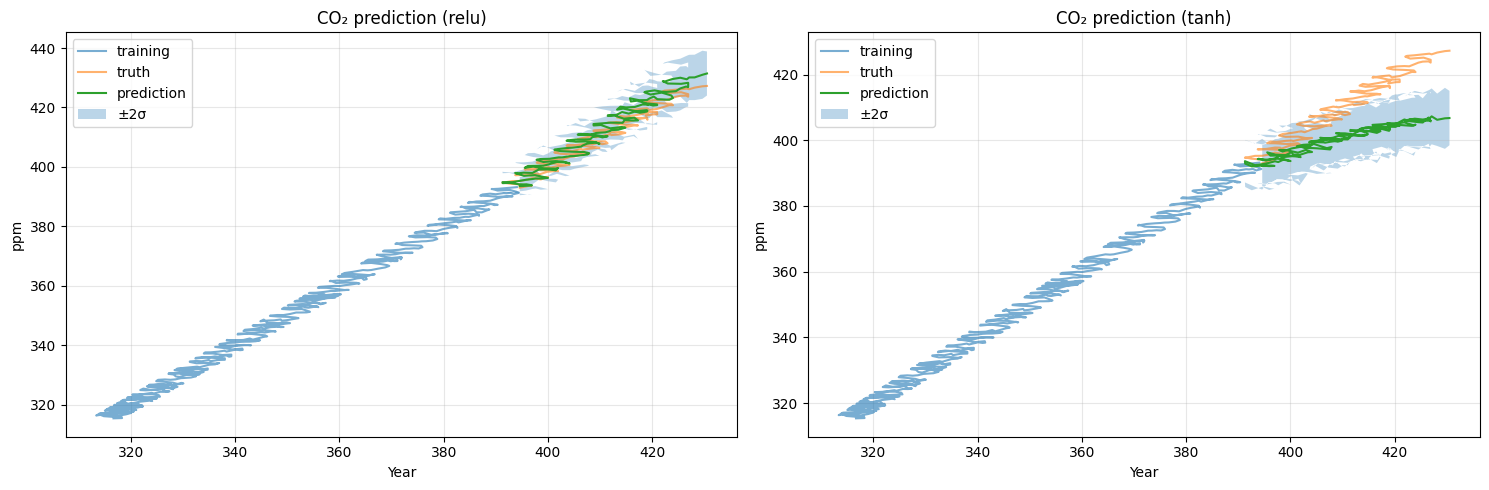

In [12]:
def load_mauna_loa_data():
    """Load Mauna Loa monthly CO₂ measurements (with a synthetic fallback)."""
    try:
        url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"
        data = pd.read_csv(url, comment='#', sep='\s+', header=None,
                           names=['year','month','decimal_date','average','interpolated','trend','days'])
        dates = data['decimal_date'].values
        co2   = data['average'].values
        mask  = co2 > 0
        return dates[mask], co2[mask]
    except Exception:
        print("Failed to download CO₂ data – using synthetic series")
        dates = np.linspace(1958, 2023, 800)
        trend = 315 + 1.7 * (dates - 1958)
        seasonal = 3 * np.sin(2 * np.pi * dates)
        noise = np.random.randn(len(dates)) * 0.5
        co2 = trend + seasonal + noise
        return dates, co2

def create_time_features(series, window=12):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

def train_co2_model(X_train, y_train, activation='relu', dropout_prob=0.1):
    input_dim = X_train.shape[1]
    model = MCDropoutNet2Layer(input_dim, 1024, 1, dropout_prob).to(DEVICE)

    if activation == 'tanh':
        def forward_tanh(self, x):
            x = self.dropout1(x)
            x = torch.tanh(self.fc1(x))
            x = self.dropout2(x)
            x = torch.tanh(self.fc2(x))
            x = self.dropout3(x)
            x = self.fc3(x)
            return x
        import types
        model.forward = types.MethodType(forward_tanh, model)

    X_train_t = torch.FloatTensor(X_train).to(DEVICE)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    model.train()
    for _ in range(200):
        optimizer.zero_grad()
        preds = model(X_train_t)
        loss  = criterion(preds, y_train_t)
        loss.backward()
        optimizer.step()
    return model

def plot_co2_predictions():
    dates, co2 = load_mauna_loa_data()
    scaler = StandardScaler()
    co2_norm = scaler.fit_transform(co2.reshape(-1,1)).squeeze()

    X, y = create_time_features(co2_norm)
    split = int(0.8 * len(X))
    X_tr, X_te = X[:split], X[split:]
    y_tr, y_te = y[:split], y[split:]
    test_dates = dates[split+12:]  # align

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    for i, act in enumerate(['relu','tanh']):
        model = train_co2_model(X_tr, y_tr, activation=act)
        mean_pred, var_pred, _ = mc_dropout_predict(
            model, torch.FloatTensor(X_te).to(DEVICE), n_samples=100)
        mean_pred = mean_pred.squeeze()
        std_pred  = np.sqrt(var_pred.squeeze())

        y_te_orig     = scaler.inverse_transform(y_te.reshape(-1,1)).squeeze()
        mean_pred_orig = scaler.inverse_transform(mean_pred.reshape(-1,1)).squeeze()
        std_pred_orig  = std_pred * scaler.scale_

        ax = axes[i]
        ax.plot(dates[12:split+12], scaler.inverse_transform(y_tr.reshape(-1,1)).squeeze(),
                label='training', alpha=0.6)
        ax.plot(test_dates, y_te_orig, label='truth', alpha=0.6)
        ax.plot(test_dates, mean_pred_orig, label='prediction')
        ax.fill_between(test_dates,
                        mean_pred_orig - 2*std_pred_orig,
                        mean_pred_orig + 2*std_pred_orig,
                        alpha=0.3, label='±2σ')
        ax.set_title(f"CO₂ prediction ({act})")
        ax.set_xlabel('Year')
        ax.set_ylabel('ppm')
        ax.legend()
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Running Mauna Loa CO₂ experiment…")
plot_co2_predictions()

## Experiment 3: Solar Irradiance Interpolation

Running solar irradiance experiment…


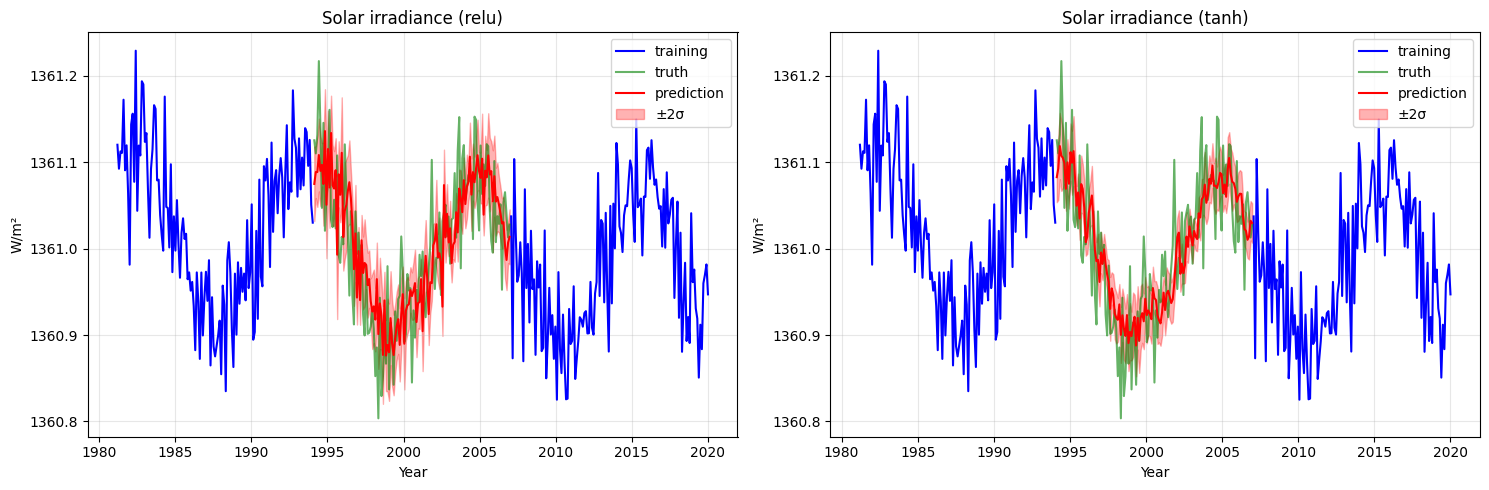

In [ ]:
def generate_solar_data():
    dates = np.linspace(1980, 2020, 400)
    cycle = 0.1 * np.sin(2 * np.pi * dates / 11)
    trend = -0.001 * (dates - 2000)
    noise = np.random.randn(len(dates)) * 0.05
    irradiance = 1361 + cycle + trend + noise
    return dates, irradiance

def plot_solar_predictions():
    dates, irradiance = generate_solar_data()
    scaler = StandardScaler()
    irr_norm = scaler.fit_transform(irradiance.reshape(-1,1)).squeeze()

    X, y = create_time_features(irr_norm)
    gap_start = len(X)//3
    gap_end   = 2*len(X)//3

    X_tr = np.concatenate([X[:gap_start], X[gap_end:]])
    y_tr = np.concatenate([y[:gap_start], y[gap_end:]])
    X_gap = X[gap_start:gap_end]
    y_gap = y[gap_start:gap_end]
    gap_dates = dates[gap_start+12:gap_end+12]

    fig, axes = plt.subplots(1,2, figsize=(15,5))
    for i, act in enumerate(['relu','tanh']):
        model = train_co2_model(X_tr, y_tr, activation=act)
        mean_pred, var_pred, _ = mc_dropout_predict(
            model, torch.FloatTensor(X_gap).to(DEVICE), n_samples=100)
        mean_pred = mean_pred.squeeze()
        std_pred  = np.sqrt(var_pred.squeeze())

        mean_pred_orig = scaler.inverse_transform(mean_pred.reshape(-1,1)).squeeze()
        y_gap_orig     = scaler.inverse_transform(y_gap.reshape(-1,1)).squeeze()
        std_pred_orig  = std_pred * scaler.scale_

        ax = axes[i]
        # Training segments
        ax.plot(dates[12:gap_start+12],
                scaler.inverse_transform(y_tr[:gap_start].reshape(-1,1)).squeeze(),
                'b-', label='training')
        ax.plot(dates[gap_end+12:gap_end+12+len(y_tr[gap_start:])],
                scaler.inverse_transform(y_tr[gap_start:].reshape(-1,1)).squeeze(),
                'b-')
        # Gap truth & prediction
        ax.plot(gap_dates, y_gap_orig, 'g-', alpha=0.6, label='truth')
        ax.plot(gap_dates, mean_pred_orig, 'r-', label='prediction')
        ax.fill_between(gap_dates,
                        mean_pred_orig-2*std_pred_orig,
                        mean_pred_orig+2*std_pred_orig,
                        alpha=0.3, color='red', label='±2σ')
        ax.set_title(f"Solar irradiance ({act})")
        ax.set_xlabel('Year')
        ax.set_ylabel('W/m²')
        ax.legend()
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Running solar irradiance experiment…")
plot_solar_predictions()

## Experiment 4: MNIST Rotated‑Digit Uncertainty

Running MNIST uncertainty experiment… (this may take a few minutes)


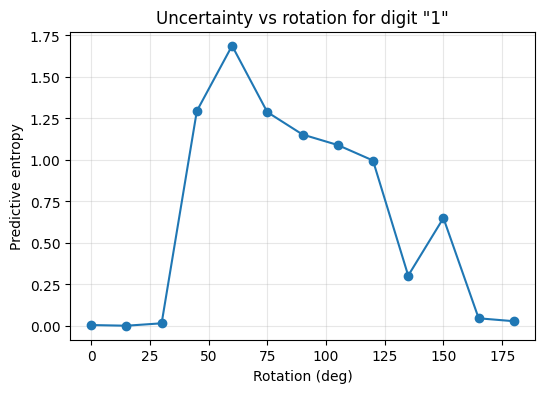

In [19]:
class MCDropoutLeNet5(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=0)   # 32x32 -> 28x28
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(84, 10)
        self.dropout2 = nn.Dropout(dropout_prob)
    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = torch.tanh(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
def patched_lenet5():
    model = MCDropoutLeNet5()
    return model.to(DEVICE)

def rotate_tensor(img_tensor, angle):
    from torchvision.transforms.functional import rotate
    return rotate(img_tensor, float(angle), fill=0)


def compute_entropy(p):
    p = np.clip(p, 1e-8, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def train_mnist_model():
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    model = patched_lenet5()
    opt = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(100):
        for Xb, yb in trainloader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(Xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
    return model

def analyze_rotated_digit():
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
    idx = next(i for i,(img,label) in enumerate(testset) if label == 1)
    img,_ = testset[idx]

    model = train_mnist_model()
    angles = np.arange(0,181,15)
    entropies = []
    for a in angles:
        rot = rotate_tensor(img, a).unsqueeze(0).to(DEVICE)
        model.eval()
        enable_dropout(model)
        with torch.no_grad():
            preds = []
            for i in range(100):
                preds.append(torch.softmax(model(rot), dim=1).cpu().numpy())
        preds = np.array(preds).squeeze()
        mean_p = preds.mean(axis=0, keepdims=True)
        entropies.append(compute_entropy(mean_p)[0])
    plt.figure(figsize=(6,4))
    plt.plot(angles, entropies, 'o-')
    plt.xlabel('Rotation (deg)')
    plt.ylabel('Predictive entropy')
    plt.title('Uncertainty vs rotation for digit "1"')
    plt.grid(alpha=0.3)
    plt.show()

print("Running MNIST uncertainty experiment… (this may take a few minutes)")
analyze_rotated_digit()

## Experiment 5: Reinforcement‑Learning Catch Game

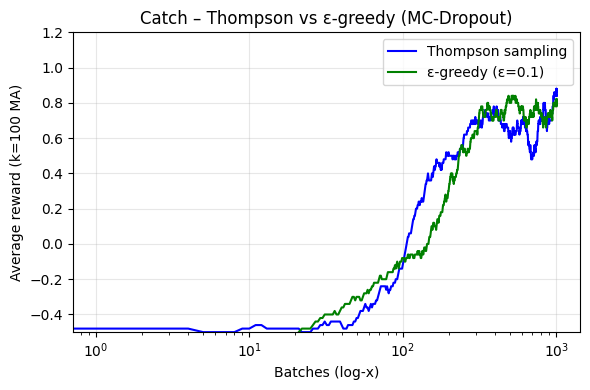

In [22]:
# ================================================================
# Catch RL  –  Thompson-sampling (MC-Dropout) vs ε-Greedy
# Gal & Ghahramani 2016  (Figure 6 reproduction)
# ================================================================
import random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from collections import deque
from tqdm.auto import trange
torch.manual_seed(0); np.random.seed(0); random.seed(0)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Environment
class Catch:
    def __init__(self, grid=10):
        self.grid = grid
        self.reset()
    def reset(self):
        self.row, self.col = 0, np.random.randint(self.grid)
        self.basket = self.grid // 2
        self.done = False
        return self._state()
    def step(self, a):
        if   a==0 and self.basket>0:   self.basket-=1
        elif a==2 and self.basket<self.grid-1: self.basket+=1
        self.row +=1
        r=0.0
        if self.row==self.grid-1:
            r = 1.0 if abs(self.col-self.basket)<=1 else -1.0
            self.done=True
        return self._state(), r, self.done
    def _state(self):
        S = np.zeros((self.grid,self.grid),dtype=np.float32)
        if not self.done:
            S[self.row,self.col]=1.0
        S[self.grid-1,
          max(0,self.basket-1):min(self.grid,self.basket+2)] = 2.0
        return S.flatten()

# 2. MC-Dropout Q-network
class DropoutQ(nn.Module):
    def __init__(self, s_dim, hidden=128, a_dim=3, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(p),
            nn.Linear(s_dim, hidden), nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, a_dim)
        )
    def forward(self, x):
        return self.net(x)

# 3. Training loop
def run(strategy="thompson", steps=10_000, γ=0.99):
    env    = Catch()
    online = DropoutQ(env.grid**2).to(DEVICE)
    target = DropoutQ(env.grid**2).to(DEVICE)
    target.load_state_dict(online.state_dict())
    opt = torch.optim.Adam(online.parameters(), lr=1e-3)

    buf     = deque(maxlen=5_000)
    rewards = []
    ep_r    = 0.0
    s       = env.reset()

    for t in trange(steps, desc=strategy, leave=False):
        s_t = torch.tensor(s, device=DEVICE).unsqueeze(0)

        # ---- action selection ----
        if strategy=="thompson":
            # single dropout sample
            online.eval()
            for m in online.modules():
                if isinstance(m, nn.Dropout): m.train()
            q = online(s_t)                    # one stochastic pass
            a = int(q.argmax(1))               # greedy w.r.t. that sample
        else:  # ε-greedy
            if random.random()<0.1:
                a = random.randint(0,2)
            else:
                with torch.no_grad():
                    a = int(online(s_t).argmax(1))

        # ---- environment step ----
        ns, r, done = env.step(a)
        buf.append((s,a,r,ns,done))
        s = ns; ep_r += r

        if done:
            rewards.append(ep_r)
            ep_r = 0.0
            s = env.reset()

        # ---- SGD update ----
        if len(buf)>=64:
            batch = random.sample(buf,64)
            S, A, Rw, Ns, D = zip(*batch)
            S  = torch.tensor(S, device=DEVICE)
            A  = torch.tensor(A, device=DEVICE).unsqueeze(1)
            Rw = torch.tensor(Rw,device=DEVICE)
            Ns = torch.tensor(Ns,device=DEVICE)
            D  = torch.tensor(D,device=DEVICE)

            q_sa = online(S).gather(1,A).squeeze()
            with torch.no_grad():
                qn = target(Ns).max(1).values
                y  = Rw + γ * qn * (~D)
            loss = F.mse_loss(q_sa, y)

            opt.zero_grad(); loss.backward(); opt.step()

        # ---- target network sync ----
        if t % 500 == 0:
            target.load_state_dict(online.state_dict())

    return rewards

# 4. Execute & plot
if __name__=="__main__":
    r_th  = run("thompson")
    r_eps = run("epsilon")

    def smooth(x, k=100):
        x = np.array(x, dtype=np.float32)
        return np.convolve(x, np.ones(k)/k, mode="valid") if len(x)>=k else x

    plt.figure(figsize=(6,4))
    plt.semilogx(smooth(r_th),  label="Thompson sampling", color="blue")
    plt.semilogx(smooth(r_eps), label="ε-greedy (ε=0.1)", color="green")
    plt.xlabel("Batches (log-x)")
    plt.ylabel("Average reward (k=100 MA)")
    plt.ylim(-0.5,1.2)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Catch – Thompson vs ε-greedy (MC-Dropout)")
    plt.tight_layout()
    plt.show()


### References

- OpenAI (2025). *ChatGPT*. [https://chat.openai.com/chat](https://chat.openai.com/chat). Accessed June 12,2025.
